In [1]:
import ROOT

Welcome to JupyROOT 6.16/00


In [8]:
file = ROOT.TFile.Open("../output/Charmonium2018B_test/jpsi_charmonium_2018B.root")

mass = ROOT.RooRealVar("mass", "", 2.95, 3.25)
data = ROOT.RooDataSet("data", "", file.Jpsi, ROOT.RooArgSet(mass))

[#1] INFO:Eval -- RooAbsReal::attachToTree(mass) TTree Float_t branch mass will be converted to double precision


In [9]:
#Signal PDFs

## Signal PDF: Crystal ball and gaussian

yield_gauss = ROOT.RooRealVar("yield_gauss","", 1e6, 0, 1e7)
mean = ROOT.RooRealVar("mean", "", 3.09, 2.95, 3.25)
sigma_gauss = ROOT.RooRealVar("sigma gauss", "", 0.1, 0.000001, 1)

yield_cb = ROOT.RooRealVar("yield_cb","", 1e6, 0, 1e7)
sigma_cb = ROOT.RooRealVar("sigma cb", "", 0.1, 0.000001, 1)

alpha = ROOT.RooRealVar("alpha", "", 1.4, 0, 10)
n = ROOT.RooRealVar("n", "", 99, 0, 100)
n.setConstant(True)

gauss = ROOT.RooGaussian("gauss", "", mass, mean, sigma_gauss)
crystal_ball = ROOT.RooCBShape("crystal ball", "", mass, mean, sigma_cb, alpha, n)


In [10]:
# Background PDF
yield_back = ROOT.RooRealVar("yield_back", "", 1e6, 0, 1e7)
exp_coef = ROOT.RooRealVar("exp_coef", "", 0, -5, 5)

back_exp = ROOT.RooExponential("back_exp", "", mass, exp_coef)

In [11]:
# Model definition and fitting
model = ROOT.RooAddPdf("model", "", ROOT.RooArgList(gauss, crystal_ball, back_exp),
                       ROOT.RooArgList(yield_gauss, yield_cb, yield_back))

In [ ]:
result = model.fitTo(data, ROOT.RooFit.Extended(True), ROOT.RooFit.Range(2.95, 3.25))

In [12]:
frame = mass.frame(ROOT.RooFit.Title("Jpsi"))
data.plotOn(frame)
model.plotOn(frame)
frame.Draw()

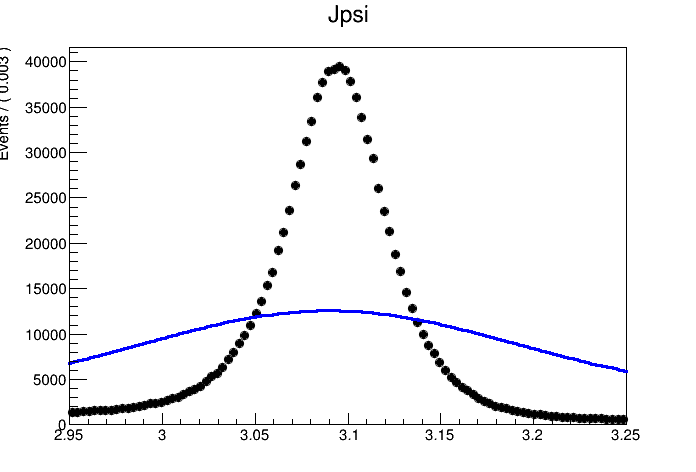

In [13]:
from ROOT import gROOT
gROOT.GetListOfCanvases().Draw()